# From FITS to HDF5

Purpose of this notebook is to get the data to suitable
data structure for preprocessing.

## FITS file format

https://fits.gsfc.nasa.gov/fits_primer.html

Flexible Image Transport System is data format used within
astronomy for transporting, analyzing, archiving scientific
data files. It is design to store data sets consisting of
multidimensiional arrays and two dimensional tables.

In [1]:
%matplotlib inline

In [2]:
import os
import glob
import random
import h5py
import astropy.io.fits
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# find the normalized spectra in data_path directory
# add all filenames to the list fits_paths
FITS_DIR = 'data/ondrejov/'
fits_paths = glob.glob(FITS_DIR + '*.fits')
len(fits_paths)

13335

In [4]:
# pick random fits
random_fits = random.choice(fits_paths)
random_fits

'data/ondrejov/si270051.fits'

### HDUs

A FITS file is comprised of segmets called Header/Data
Units (HDUs). The first HDU is called the 'Primary HDU'.
The primary data array can contain a 1-999 dimensional
array of numbers. A typical primary array could contain
a 1 dimensional **spectrum**, a 2 dimensional image,
a 3 dimensional data cube.

Any number of additional HDUs may follow the primary array.
These HDUs are referred as 'extensions'. There are three
types of standart extensions currently defined:

1. Image Extension (`XTENSION = 'IMAGE'`)
2. ASCII Table Extension (`XTENSION = 'TABLE'`)
3. Binary Table Extension (`XTENSION = 'BINTABLE'`)

In [5]:
# open file with astropy
hdulist = astropy.io.fits.open(random_fits)
# display info about the HDUs
hdulist.info()

Filename: data/ondrejov/si270051.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       5   ()      
  1              BinTableHDU     39   1757R x 2C   [D, D]   


### Header Units

Every HDU consists of an ASCII formatted 'Header Unit' and
'Data Unit'.

Each header unit contains a sequence of fixed-length 80
character long keyword record which have form:

    KEYNAME = value / comment string

Non-printing ASCII character such as tabs,
carriage-returns, line-feeds are not allowed anywhere in
the header unit.

In [6]:
hdulist[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / More exts following                            
DATE    = '2017-04-07'         / Date file was written                          

In [7]:
hdulist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                 1757 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'spectral'           / Air wavelength                                 
TFORM1  = 'D       '                                                            
TUNIT1  = 'Angstrom'                                                            
TTYPE2  = 'flux    '           / Relative flux                                  
TFORM2  = 'D       '        

### Data Units

Note that the data unit is not required. The image pixels
in primary array or an image extension may have one of
5 supported data types:

* 8-bit (unsigned) integer bytes
* 16-bit (signed) integer bytes
* 32-bit (signed) integer bytes
* 32-bit single precision floating point real numbers
* 64-bit double precision floating point real numbers

The othe 2 standard extensions, ASCII tables and binary
tables, contain tabular information organized into rows
and columns. Binary tables are more compact and are faster
to read and write then ASCII tables.

All the entries within a column of a tables have the same
datatype. The allowed data formats for an ASCII table
column are: integer, signe and double precision floating
point value, character string. Binary table also support
logical, bit and complex data formats.

In [8]:
data = hdulist[1].data
data

FITS_rec([( 6282.15096701,  0.95686185), ( 6282.40768203,  0.94429642),
       ( 6282.66439705,  0.9415493 ), ..., ( 6732.42911048,  0.99979796),
       ( 6732.6858255 ,  1.00058314), ( 6732.94254051,  1.0003216 )], 
      dtype=(numpy.record, [('spectral', '>f8'), ('flux', '>f8')]))

In [9]:
flux = data.field('flux').astype(np.float64, order='C', copy=True)
wave = data.field('spectral').astype(np.float64, order='C', copy=True)
flux.shape, wave.shape

((1757,), (1757,))

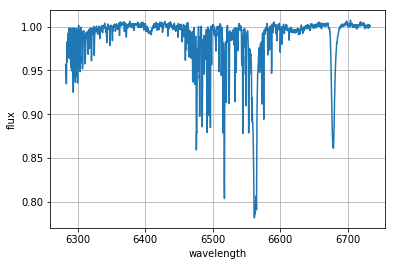

In [10]:
plt.plot(wave, flux)
plt.ylabel('flux')
plt.xlabel('wavelength')
plt.grid(True)

## FITS parsing

Parse interesting thing from FITS file:

* wave
* flux
* date
* ra
* dec

In [11]:
def parse_fits_id(path):
    return os.path.splitext(os.path.split(path)[-1])[0]

# http://astropy.readthedocs.io/en/latest/io/fits/appendix/faq.html#i-m-opening-many-fits-files-in-a-loop-and-getting-oserror-too-many-open-files
def parse_fits(filename):
    '''Parse normalized spectrum from fits file.'''
    try:
        with astropy.io.fits.open(filename, mmap=False) as hdulist:
            data = hdulist[1].data
            header = hdulist[1].header
            wave = data['spectral'].astype(np.float64, order='C', copy=True)
            flux = data['flux'].astype(np.float64, order='C', copy=True)
            date = header['DATE']
            ra = header['RA']
            dec = header['DEC']
    except IOError as e:
        print(e, filename)
        return None, None
    return parse_fits_id(filename), {
        'wave': wave,
        'flux': flux,
        'date': date,
        'ra': ra,
        'dec': dec,
    }   

parse_fits(random_fits)

('si270051',
 {'date': '2009-09-28T07:24:05',
  'dec': -0.2990833330751612,
  'flux': array([ 0.95686185,  0.94429642,  0.9415493 , ...,  0.99979796,
          1.00058314,  1.0003216 ]),
  'ra': 83.0016666680326,
  'wave': array([ 6282.15096701,  6282.40768203,  6282.66439705, ...,  6732.42911048,
          6732.6858255 ,  6732.94254051])})

In [12]:
H_ALPHA = 6562.8

def in_range(start, stop, val=H_ALPHA):
    '''Check if val is in range [start, stop]'''
    return start <= val <= stop

def in_wavelen(wavelens, val=H_ALPHA):
    '''Check if val is somewhere in-between wavelens
    array start and end.'''
    return wavelens is not None and in_range(wavelens[0], wavelens[-1], val)

In [ ]:
# the data stucture is dict where a key is spectrum id
# and a value is dict of wavelen and flux
spectra = {
    fits_id: data_dict
    for fits_id, data_dict in map(parse_fits, fits_paths)
    if in_wavelen(wave, H_ALPHA)
}
len(spectra)

## Save to HDF5

In [ ]:
with h5py.File('data/data.hdf5', 'w') as f:
    for ident, data in spectra.items():
        wave = data['wave']
        flux = data['flux']
        group = 'spectra/' + ident
        dset = f.create_dataset(group, (2, wave.shape[0]), dtype=wave.dtype)
        dset[0, :] = wave
        dset[1, :] = flux
        dset.attrs['date'] = data['date']
        dset.attrs['dec'] = data['dec']
        dset.attrs['ra'] = data['ra']